# Final Project – Glass Identification Data Set Modeling

Name: Qixiao Zhu
Class: CSCI 349 - Intro to Data Mining
Semester: Spring 2023
Instructor: Brian King

# Summary

This is my first time dealing with imbalanced data. I tried two methods, one of them is using the weighted f1 score as the performance metric, and the other is oversampling using SMOTE. Although the end result is not great (accuracy of only around 0.75 when testing using a portion of the original data), I believe that this method is better than using the weighted f1 score. This data might be too severely imbalanced, and there are really not a lot of samples to train from. In my opinion, oversampling does not represent the real data very well, and it is easy to overfit on the oversampled training data. For my final step, I will summarize everything and make sure that I express everything clearly.

# Preprocessing

In [611]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Model
from keras.layers import Input, Dense
from scikeras.wrappers import KerasClassifier

In [582]:
df = pd.read_csv("./data/glass.data", index_col=0, names=["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type of glass"])
df.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type of glass
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


Check if all the columns are in the correct types.

In [583]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RI             214 non-null    float64
 1   Na             214 non-null    float64
 2   Mg             214 non-null    float64
 3   Al             214 non-null    float64
 4   Si             214 non-null    float64
 5   K              214 non-null    float64
 6   Ca             214 non-null    float64
 7   Ba             214 non-null    float64
 8   Fe             214 non-null    float64
 9   Type of glass  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


In [584]:
df["Type of glass"] = df["Type of glass"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   RI             214 non-null    float64 
 1   Na             214 non-null    float64 
 2   Mg             214 non-null    float64 
 3   Al             214 non-null    float64 
 4   Si             214 non-null    float64 
 5   K              214 non-null    float64 
 6   Ca             214 non-null    float64 
 7   Ba             214 non-null    float64 
 8   Fe             214 non-null    float64 
 9   Type of glass  214 non-null    category
dtypes: category(1), float64(9)
memory usage: 17.1 KB


From the description, there is no NaN element in this dataframe, so no need to worry about empty variables. Also from the description, there is no 4 in target classes, so in reality only 6 classes in total.

---
# Modeling

In [585]:
# Separate the data into variables and target classes

X = df.loc[:, "RI":"Fe"]
y = df.loc[:, "Type of glass"]

# Normalize the data
X = zscore(X)
X.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
1,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
2,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
3,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
4,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
5,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451
6,-0.793931,-0.758384,0.643117,0.351521,0.412905,0.219689,-0.624699,-0.352877,2.088150
7,-0.308744,-0.132382,0.636168,-0.612137,0.568197,0.127475,-0.554268,-0.352877,-0.586451
8,-0.265836,-0.316500,0.643117,-0.792823,0.762313,0.112107,-0.504966,-0.352877,-0.586451
9,0.268859,0.775936,0.622270,-0.150384,-0.738850,0.096738,-0.462707,-0.352877,-0.586451
10,-0.269137,-0.500618,0.636168,-0.170460,0.438787,0.112107,-0.392276,-0.352877,0.545111


In [586]:
# Shuffle the data

X_shuffled, y_shuffled = shuffle(X, y, random_state=0)

In [587]:
# binarize y

y_binarized = pd.get_dummies(y_shuffled)
y_binarized.head(10)

,1,2,3,5,6,7
198,0,0,0,0,0,1
38,1,0,0,0,0,0
90,0,1,0,0,0,0
177,0,0,0,0,1,0
171,0,0,0,1,0,0
76,0,1,0,0,0,0
97,0,1,0,0,0,0
138,0,1,0,0,0,0
6,1,0,0,0,0,0
84,0,1,0,0,0,0


In [588]:
# Make sure that the index of X and y match

X_shuffled.head(10)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
198,-0.361554,1.586056,-1.865511,1.797009,0.814078,-0.763919,-0.004904,0.977618,-0.586451
38,-0.130512,-0.819757,0.552779,-0.190536,0.399964,0.219689,-0.195068,-0.352877,-0.586451
90,-0.648705,-1.052973,0.552779,0.853427,0.749372,0.204320,-0.617656,-0.352877,0.339372
177,0.225952,0.726837,-0.204674,0.231064,-0.363559,-0.763919,0.431770,-0.352877,-0.586451
171,1.757426,0.039462,-1.865511,0.271217,-0.557675,-0.272115,2.312284,-0.352877,-0.586451
76,-0.813735,-0.476069,0.622270,0.130683,0.607021,0.296533,-0.702173,-0.352877,-0.586451
97,0.014714,-0.476069,0.650066,-0.772747,-0.402382,0.219689,0.121872,-0.352877,0.956588
138,-0.414363,-0.635638,0.650066,0.251140,0.399964,0.173582,-0.596526,-0.352877,-0.586451
6,-0.793931,-0.758384,0.643117,0.351521,0.412905,0.219689,-0.624699,-0.352877,2.088150
84,-0.800532,-0.390147,0.580575,0.210988,0.283494,0.281164,-0.638785,-0.352877,0.339372


Next we will need to specify the structure of the model.

In [589]:
# This is a neural network model with 9 inputs, 2 hidden layers, and 6 outputs.

def create_keras_model(num_hidden, activation):

    # glass has 9 predictor variables
    inputs = Input(shape=(9,))

    # our hidden layer is parameterized
    layer_1 = Dense(num_hidden, activation=activation)(inputs)

    layer_2 = Dense(num_hidden, activation=activation)(layer_1)

    # we have a 6-class problem, and we'll hard-code softmax activation
    outputs = Dense(6, activation="softmax")(layer_2)

    # Build our model
    model = Model(inputs=inputs, outputs=outputs, name="model_1")

    return model

The classes are imbalanced. To minimize the effect of this problem, weighted f1 performance metric is used.

In [590]:
# Define a custom scorer for F1 score
f1_scorer = make_scorer(f1_score, average='weighted')

In [591]:
%%time

param_grid = { 'optimizer': ['adam'],
               'model__num_hidden': [50, 60],
               'model__activation': ['relu'],
               'epochs': [85, 100],
               'batch_size': [4, 5, 7]
             }

clf = KerasClassifier(model=create_keras_model, loss='categorical_crossentropy', verbose=0)

grid = GridSearchCV(clf, param_grid,
                    return_train_score=True, cv=5,
                    scoring=f1_scorer,
                    verbose=2, n_jobs=-1)
grid_result = grid.fit(X_shuffled, y_binarized)

df_grid_results = pd.DataFrame(grid_result.cv_results_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 1min 27s
Wall time: 1min 15s


In [592]:
# summarize results
grid_result.best_score_

0.723607093572247

In [593]:
grid_result.best_params_

{'batch_size': 5,
 'epochs': 100,
 'model__activation': 'relu',
 'model__num_hidden': 60,
 'optimizer': 'adam'}

In [594]:
df_grid_results.sort_values('mean_test_score', ascending=False).reset_index(drop=True).loc[:,['param_batch_size', 'param_epochs', 'param_model__activation', 'param_model__num_hidden', 'param_optimizer', 'mean_train_score', 'mean_test_score']]

,param_batch_size,param_epochs,param_model__activation,param_model__num_hidden,param_optimizer,mean_train_score,mean_test_score
0,5,100,relu,60,adam,0.978008,0.723607
1,7,100,relu,50,adam,0.957871,0.722907
2,4,85,relu,50,adam,0.967257,0.711487
3,4,100,relu,50,adam,0.967334,0.706681
4,5,85,relu,60,adam,0.970863,0.706066
5,7,85,relu,60,adam,0.951836,0.705060
6,5,85,relu,50,adam,0.962594,0.703246
7,7,100,relu,60,adam,0.967376,0.698779
8,4,100,relu,60,adam,0.981365,0.690067
9,5,100,relu,50,adam,0.976679,0.689397


The class imbalance might be too severe. Since there are not many samples, we will try oversampling the data and see if it works better.

In [595]:
# Use SMOTE to oversample the data so that each class has the same number of samples
oversample = SMOTE()
X_oversampled, y_oversampled = oversample.fit_resample(X_shuffled, y_shuffled)
y_oversampled.value_counts()

1    76
2    76
3    76
5    76
6    76
7    76
Name: Type of glass, dtype: int64

In [596]:
# Binarize the oversampled y
y_oversampled = pd.get_dummies(y_oversampled)
y_oversampled.shape

(456, 6)

In [597]:
X_oversampled.shape

(456, 9)

In [598]:
%%time

param_grid = { 'optimizer': ['adam'],
               'model__num_hidden': [30, 75],
               'model__activation': ['relu'],
               'epochs': [90, 130],
               'batch_size': [3, 20]
             }

clf = KerasClassifier(model=create_keras_model, loss='categorical_crossentropy', verbose=0)

grid = GridSearchCV(clf, param_grid,
                    return_train_score=True, cv=5,
                    scoring='accuracy',
                    verbose=2, n_jobs=-1)
grid_result = grid.fit(X_oversampled, y_oversampled)

df_grid_results = pd.DataFrame(grid_result.cv_results_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 6min 53s
Wall time: 1min 54s


In [599]:
# summarize results
grid_result.best_score_

0.8906593406593407

In [600]:
grid_result.best_params_

{'batch_size': 3,
 'epochs': 130,
 'model__activation': 'relu',
 'model__num_hidden': 30,
 'optimizer': 'adam'}

In [601]:
df_grid_results.sort_values('mean_test_score', ascending=False).reset_index(drop=True).loc[:,['param_batch_size', 'param_epochs', 'param_model__activation', 'param_model__num_hidden', 'param_optimizer', 'mean_train_score', 'mean_test_score']]

,param_batch_size,param_epochs,param_model__activation,param_model__num_hidden,param_optimizer,mean_train_score,mean_test_score
0,3,130,relu,30,adam,0.992874,0.890659
1,3,130,relu,75,adam,0.998904,0.888485
2,20,90,relu,75,adam,0.981912,0.886312
3,20,130,relu,75,adam,0.986846,0.884114
4,3,90,relu,75,adam,0.993423,0.881940
5,3,90,relu,30,adam,0.984655,0.862183
6,20,130,relu,30,adam,0.970948,0.862183
7,20,90,relu,30,adam,0.955603,0.855566


We can see that it is much more effective when we oversample the data before training the model. We will then test the best model by splitting the data into training and testing data.

In [602]:
# Split the data into 80% train and 20% test data
X_train, X_test, y_train, y_test = \
    train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=0)

# Use SMOTE to oversample the training data so that each class has the same number of samples
oversample = SMOTE()
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)
y_train_oversampled.value_counts()

1    60
2    60
3    60
5    60
6    60
7    60
Name: Type of glass, dtype: int64

In [603]:
# Binarize the oversampled y
y_train_oversampled = pd.get_dummies(y_train_oversampled)
y_train_oversampled.shape

(360, 6)

In [604]:
X_train_oversampled.shape

(360, 9)

In [605]:
# create the model using the relu activation function and 75 nodes in each hidden layer
model = create_keras_model(75, 'relu')

# compile the model using adam as the optimizer, categorical crossentropy as the loss, and weighted f1 as the performance metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [606]:
# train the model, the output history is a dictionary containing
# information of accuracy and loss for every step
history = model.fit(X_train_oversampled, y_train_oversampled,
                    epochs=35, batch_size=3, verbose=1,
                    validation_data=(X_test, pd.get_dummies(y_test)))

Epoch 1/35
120/120 [==============================] - 1s 5ms/step - loss: 1.2771 - accuracy: 0.5750 - val_loss: 1.3471 - val_accuracy: 0.4186
Epoch 2/35
120/120 [==============================] - 0s 2ms/step - loss: 0.7279 - accuracy: 0.7667 - val_loss: 1.0922 - val_accuracy: 0.6977
Epoch 3/35
120/120 [==============================] - 0s 2ms/step - loss: 0.5444 - accuracy: 0.8000 - val_loss: 1.0072 - val_accuracy: 0.6512
Epoch 4/35
120/120 [==============================] - 0s 2ms/step - loss: 0.4531 - accuracy: 0.8417 - val_loss: 0.9895 - val_accuracy: 0.6744
Epoch 5/35
120/120 [==============================] - 0s 2ms/step - loss: 0.3931 - accuracy: 0.8667 - val_loss: 0.9600 - val_accuracy: 0.6744
Epoch 6/35
120/120 [==============================] - 0s 2ms/step - loss: 0.3561 - accuracy: 0.8806 - val_loss: 0.9244 - val_accuracy: 0.6279
Epoch 7/35
120/120 [==============================] - 0s 2ms/step - loss: 0.3158 - accuracy: 0.8833 - val_loss: 0.9548 - val_accuracy: 0.6512
Epoch 

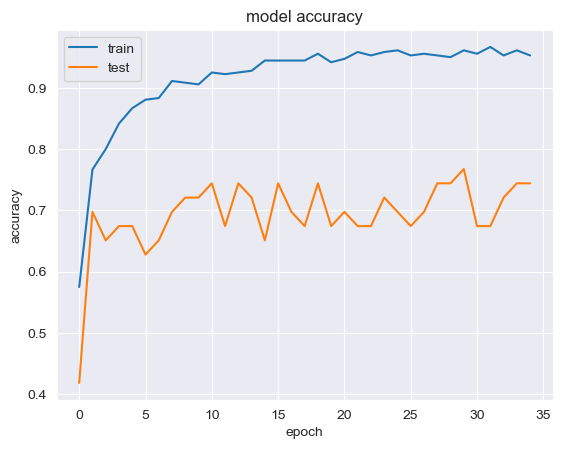

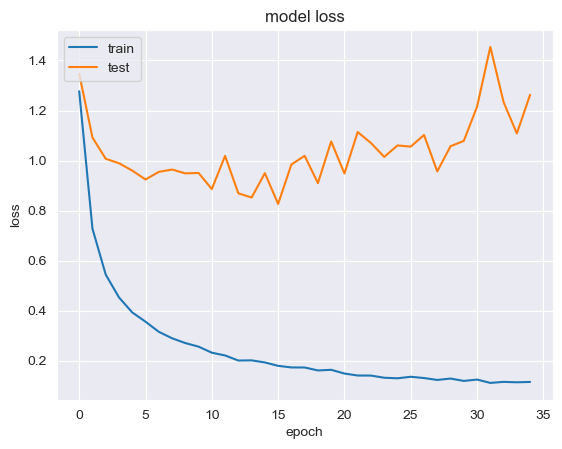

In [607]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [608]:
y_pred = model.predict(X_test)
y_pred = pd.Series(np.argmax(y_pred, axis=1))
y_pred = y_pred.astype('category')
y_pred = y_pred.replace({0: '1', 1: '2', 2: '3', 3: '5', 4: '6', 5: '7'}).astype('int').astype('category')
y_pred.head(10)

2/2 [==============================] - 0s 102ms/step


0    1
1    3
2    2
3    5
4    1
5    2
6    2
7    1
8    2
9    7
dtype: category
Categories (6, int64): [1, 2, 3, 5, 6, 7]

In [609]:
y_test = y_test.reset_index(drop=True)
y_test.head(10)

0    1
1    3
2    2
3    5
4    3
5    2
6    2
7    1
8    2
9    7
Name: Type of glass, dtype: category
Categories (6, int64): [1, 2, 3, 5, 6, 7]

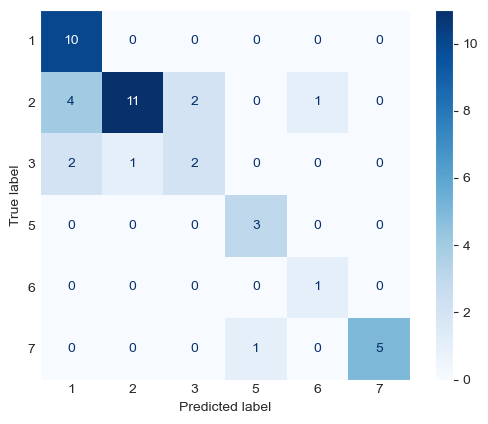

In [610]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                              display_labels=['1', '2', '3', '5', '6', '7'])
disp = disp.plot(include_values=True, ax=None, cmap=plt.cm.Blues)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(visible=None)
plt.show()

After trying it out on a train and test split data, I discovered that most of the hyperparameters are good, except the epoch. The epoch is too large and overfits the oversampled training data, so I adjusted it to a much smaller epoch. To my surprise, 2 had the biggest issue while having the least oversampling.